In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tensorflow.python.framework import ops
from cnn_utils import random_mini_batches, convert_to_one_hot
%matplotlib inline
warnings.simplefilter("ignore")
np.random.seed(1)

In [192]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [193]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [195]:
some_digit = train.iloc[1:2,1:]

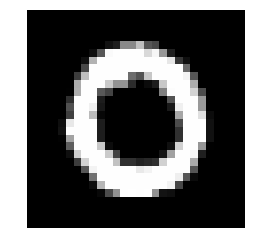

In [196]:
plt.imshow(some_digit.values.reshape(28,28), cmap="gist_gray")
plt.axis("off")
plt.show()

In [197]:
train.values.shape

(42000, 785)

In [202]:
from sklearn.model_selection import train_test_split

In [203]:
X = train.iloc[:,1:].values

In [204]:
y = train.iloc[0:,0:1].values

In [205]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train=X_train.reshape(X_train.shape[0],28,28,1)
X_test=X_test.reshape(X_test.shape[0],28,28,1)
y_train = convert_to_one_hot(y_train,10).T
y_test = convert_to_one_hot(y_test, 10).T
X_Test = test.values.reshape(test.values.shape[0],28,28,1)

In [190]:
import tensorflow as tf

In [175]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of the input image
    n_W0 -- scalar, width of the input image
    n_C0 -- scalar, number of channels of input
    n_y -- scalar, number of classes
    
    Returns:
    X -- placeholder for the input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [176]:
X, Y = create_placeholders(100, 28, 28, 10)
print("Tensor X:", X)
print("Tensor Y:", Y)

Tensor X: Tensor("Placeholder_2:0", shape=(?, 100, 28, 28), dtype=float32)
Tensor Y: Tensor("Placeholder_3:0", shape=(?, 10), dtype=float32)


In [177]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                       W1 : [5,5,1,6]
                       W2 : [5,5,6,16]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [5,5,1,6], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5,5,6,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters  

In [178]:
def forward_propagation(X, parameters):
    """ 
    Implements the forward propagation for the model LeNet:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> RELU -> FLATTEN -> FULLYCONNECTED
    
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing the parameters "W1" , "W2"
                  the shapes are given in initialize parameters
    
    Returns:
    Z3 -- the output of the linear unit
    
    """
    
    W1 = parameters ["W1"]
    W2 = parameters ["W2"]
    
    #CONV2D stride = 1 padding valid
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="VALID")
    
    #RELU
    A1 = tf.nn.relu(Z1)
    
    #MAXPOOL window 2x2, stride = 2, padding 'VALID'
    P1 = tf.nn.max_pool(A1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
    
    #CONV2D: filters W2, stride 1, padding 'Valid'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="VALID")
    
    #RELU
    A2 = tf.nn.relu(Z2)
    
    #MAXPOOL window 2x2, stride = 2, padding 'VALID'
    P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
    
    #Flatten
    P2 = tf.contrib.layers.flatten(P2)
    
    #Fully Connected
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)
    
    return Z3    

In [184]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(32,32,1,10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,32,32,1) , Y:np.random.randn(2,10)})
    print("Z3 = ", a.shape)

Z3 =  (2, 10)


In [180]:
def compute_cost(Z3, Y):
    """
    Compute the cost
    
    Arguments:
    Z3 -- Output of forward propagation (output of the last LINEAR unit), of shape(10, number of examples)
    Y -- "True" labels vector placeholder same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [181]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(32,32,1,10)
    #print(Y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    #print(Z3)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost , { X: np.random.randn(100,32,32,1), Y: np.random.randn(100,10)})
    print("cost = ", a)

cost =  -0.20996045


In [257]:
def model(X_train, Y_train, X_test, Y_test, X_Test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 28, 28, 3)
    Y_train -- test set, of shape (None, n_y = 10)
    X_test -- training set, of shape (None, 28, 28, 3)
    Y_test -- test set, of shape (None, n_y = 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0,n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X,parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3,Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        #print(predict_op)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        predictions = predict_op.eval({X:X_Test})
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        
        #print(predictions)
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters, predictions

Cost after epoch 0: 1.253210
Cost after epoch 5: 0.236418
Cost after epoch 10: 0.232456
Cost after epoch 15: 0.216024
Cost after epoch 20: 0.222170
Cost after epoch 25: 0.253664
Cost after epoch 30: 0.247951
Cost after epoch 35: 0.231939
Cost after epoch 40: 0.225954
Cost after epoch 45: 0.230997
Cost after epoch 50: 0.224788
Cost after epoch 55: 0.264259
Cost after epoch 60: 0.221614
Cost after epoch 65: 0.229172
Cost after epoch 70: 0.211155
Cost after epoch 75: 0.220203
Cost after epoch 80: 0.245673
Cost after epoch 85: 0.278256
Cost after epoch 90: 0.199368
Cost after epoch 95: 0.216655


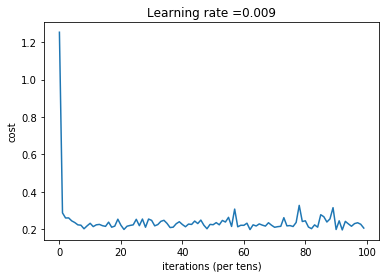

Train Accuracy: 0.95035535
Test Accuracy: 0.93030304


In [258]:
tf.reset_default_graph()
_, _, parameters, predictions = model(X_train, y_train, X_test, y_test,X_Test)

In [269]:
df_results=pd.DataFrame(predictions,columns=["Label"])

In [259]:
predictions

array([2, 0, 9, ..., 3, 9, 2])

In [279]:
df_results.index= range(1,len(df_results)+1)

In [282]:
df_results.index.name = "ImageId"

In [284]:
pd.DataFrame.to_csv(df_results, path_or_buf="data/submission.csv")